In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0,"../src_fork/")
sys.path.insert(0,"../src_fork/analysis")

import linear_regression
import utils
import stat_tools
import crossvalidation
import bootstrap
from FrankeFunction import FrankeFunction


utils.plot_settings()  # LaTeX fonts in Plots!

FIGPATH = "../figs/"
FIGURESIZE= np.array([4,3]) # Good default figure size for tex documents

In [2]:
np.random.seed(2018)
n = 500
noise_scale = 0.2
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
max_degree = 15
n_lambdas = 30
n_bootstraps = 100
k_folds = 5
lambdas = np.logspace(-5, 0, n_lambdas)
subset_lambdas = lambdas[::60]

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept

#   Centering the response
z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

########### Setup of problem is completed above.

# Quantities of interest: note the indexing, element 0 is polynomial degree 1
mse_ols_test = np.zeros(max_degree)
mse_ols_train = np.zeros(max_degree)
ols_cv_mse = np.zeros(max_degree)

ols_boot_mse = np.zeros(max_degree)
ols_boot_bias = np.zeros(max_degree)
ols_boot_variance = np.zeros(max_degree)

best_ridge_lambda = np.zeros(max_degree)
best_ridge_mse = np.zeros(max_degree)
ridge_best_lambda_boot_mse = np.zeros(max_degree)
ridge_best_lambda_boot_bias = np.zeros(max_degree)
ridge_best_lambda_boot_variance = np.zeros(max_degree)

best_lasso_lambda = np.zeros(max_degree)
best_lasso_mse = np.zeros(max_degree)
lasso_best_lambda_boot_mse = np.zeros(max_degree)
lasso_best_lambda_boot_bias = np.zeros(max_degree)
lasso_best_lambda_boot_variance = np.zeros(max_degree)

ridge_lamb_deg_mse = np.zeros((max_degree, n_lambdas))
lasso_lamb_deg_mse = np.zeros((max_degree, n_lambdas))

ridge_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))

# Actual computations
for degree_index in range(max_degree):
    degree = degree_index + 1 # Little sense in doing stuff for 0 degrees.
    X = linear_regression.design_matrix_2D(x, y, degree)
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    # Scaling and feeding to CV.
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = X_scaled[:,1:]
    #    X_scaled[:,0] = 1 # Maybe not for ridge+lasso. Don't want to penalize constants...

    # Scaling and feeding to bootstrap and OLS
    scaler_boot = StandardScaler()
    scaler_boot.fit(X_train)
    X_train_scaled = scaler_boot.transform(X_train)
    X_test_scaled = scaler_boot.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    #    X_train_scaled[:,0] = 1 #maybe not for ridge+lasso
    #    X_test_scaled[:,0] = 1 #maybe not for ridge+lasso

    # OLS, get MSE for test and train set.

    betas = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    z_test_model = X_test_scaled @ betas
    z_train_model = X_train_scaled @ betas
    mse_ols_train[degree_index] = stat_tools.MSE(z_train, z_train_model)
    mse_ols_test[degree_index] = stat_tools.MSE(z_test, z_test_model)

    # CV, find best lambdas and get mse vs lambda for given degree. Also, gets
    # ols_CV_MSE

    lasso_cv_mse, ridge_cv_mse, ols_cv_mse_deg = crossvalidation.k_fold_cv_all(
        X_scaled, z, n_lambdas, lambdas, k_folds
    )
    best_lasso_lambda[degree_index] = lambdas[np.argmin(lasso_cv_mse)]
    best_ridge_lambda[degree_index] = lambdas[np.argmin(ridge_cv_mse)]
    best_lasso_mse[degree_index] = np.min(lasso_cv_mse)
    best_ridge_mse[degree_index] = np.min(ridge_cv_mse)
    lasso_lamb_deg_mse[degree_index] = lasso_cv_mse
    ridge_lamb_deg_mse[degree_index] = ridge_cv_mse
    ols_cv_mse[degree_index] = ols_cv_mse_deg

    # All regression bootstraps at once
    lamb_ridge = best_ridge_lambda[degree_index]
    lamb_lasso = best_lasso_lambda[degree_index]

    (
        ridge_mse,
        ridge_bias,
        ridge_variance,
        lasso_mse,
        lasso_bias,
        lasso_variance,
        ols_mse,
        ols_bias,
        ols_variance,
    ) = bootstrap.bootstrap_all(
        X_train_scaled, X_test_scaled, z_train, z_test, n_bootstraps, lamb_lasso, lamb_ridge
    )

    (
        ridge_best_lambda_boot_mse[degree_index],
        ridge_best_lambda_boot_bias[degree_index],
        ridge_best_lambda_boot_variance[degree_index],
    ) = (ridge_mse, ridge_bias, ridge_variance)

    (
        lasso_best_lambda_boot_mse[degree_index],
        lasso_best_lambda_boot_bias[degree_index],
        lasso_best_lambda_boot_variance[degree_index],
    ) = (lasso_mse, lasso_bias, lasso_variance)

    ols_boot_mse[degree_index], ols_boot_bias[degree_index], ols_boot_variance[degree_index] = (
        ols_mse,
        ols_bias,
        ols_variance,
    )

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.99652639258902, tolerance: 0.0054034008139857434
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.775497523375931, tolerance: 0.004940669655820523
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.741586200465566, tolerance: 0.005305197282732918
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11208335699426186, tolerance: 0.005142022454323324
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015966272481858113, tolerance: 0.0054034008139857434
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016088298429490777, tolerance: 0.005305197282732918
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.950075399480378, tolerance: 0.004971578378367727
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.133232107604718, tolerance: 0.004854105387579269
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.395600594566954, tolerance: 0.005730171297347539
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.404029839372602, tolerance: 0.005338283762964815
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.398493048224406, tolerance: 0.005278932133721557
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3199002975752983, tolerance: 0.004825342756701312
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.601412020057504, tolerance: 0.004516710657438407
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.369492170873452, tolerance: 0.004928504668481
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.03947515914835, tolerance: 0.004867927406025102
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_desc

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.527102099502159, tolerance: 0.004515487477072125
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.040335583040417, tolerance: 0.005695975628201669
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.00806686816375, tolerance: 0.00592529690028478
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_de

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.289239863286697, tolerance: 0.00522632615393936
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.896015140512015, tolerance: 0.005159264859652766
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.582408662106424, tolerance: 0.005439088785464189
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8462859082800982, tolerance: 0.00542582691205857
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2527277121340408, tolerance: 0.004952747991554074
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5270445075551731, tolerance: 0.0050863106992714065
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.102483806642107, tolerance: 0.005809149853904837
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.129322995672267, tolerance: 0.005156164104667975
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.462357728577132, tolerance: 0.0057945399243425465
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.705733883371679, tolerance: 0.005751155842191725
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.790571328907264, tolerance: 0.005254983536681788
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.450610135060778, tolerance: 0.005700594093941788
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.71915791586304, tolerance: 0.005510672522803115
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.904647925609353, tolerance: 0.0054834462586077996
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.318735628798068, tolerance: 0.005550604292223213
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.203597539049138, tolerance: 0.004977005100193512
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.685540157887763, tolerance: 0.005211610728407879
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.954369151718733, tolerance: 0.005515945836303217
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3849651123742603, tolerance: 0.005211610728407879
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6737052938580614, tolerance: 0.005515945836303217
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2569083321521042, tolerance: 0.004852103126543743
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007489567217795923, tolerance: 0.004852103126543743
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.54528898146648, tolerance: 0.005384633883801599
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.394927814705225, tolerance: 0.005032451428546788
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.633919406249788, tolerance: 0.005205788914322324
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.974397781404725, tolerance: 0.005058087616091643
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.607861583557566, tolerance: 0.005780993782424632
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.788127314953456, tolerance: 0.005483944525783572
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.26072935936223, tolerance: 0.005340022150916627
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.361079760263934, tolerance: 0.004925402530117949
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.687415122920834, tolerance: 0.005216907743201103
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.492314226385512, tolerance: 0.005206871640476345
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.73362281659969, tolerance: 0.005084496051692489
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017159936675252396, tolerance: 0.005216907743201103
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06804544953559599, tolerance: 0.005206871640476345
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018061279322324708, tolerance: 0.005084496051692489
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.057852156077115, tolerance: 0.005148374181265055
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2209990900109737, tolerance: 0.005404191193181901
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2284156413351752, tolerance: 0.004810922468884346
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.47419992101612, tolerance: 0.005469222031072113
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6304322872276673, tolerance: 0.004831072505146294
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4268507203915357, tolerance: 0.005039068205277775
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.853119901597234, tolerance: 0.005271768750352934
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.969983372021167, tolerance: 0.005251303004641203
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.471254365713992, tolerance: 0.005048022927056838
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7115011019350348, tolerance: 0.0051121930396040354
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9230549633105447, tolerance: 0.0051778865056524345
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6015004502025931, tolerance: 0.005271768750352934
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.617772186202945, tolerance: 0.005114956508461106
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.794398960082389, tolerance: 0.004878162472784011
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.67870010716271, tolerance: 0.005503444968789355
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6065144072818507, tolerance: 0.005422857211905051
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.702340883707307, tolerance: 0.005464280377658227
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1340705662565487, tolerance: 0.0055490916924042
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.769881305145652, tolerance: 0.005647750846953301
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.578346351418845, tolerance: 0.005668952934961854
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.254087516912717, tolerance: 0.005148731517996271
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.837713093233647, tolerance: 0.005089086635257977
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.82974855853102, tolerance: 0.005280189373748591
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.54874850346188, tolerance: 0.005266757873340042
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_de

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008277191717017018, tolerance: 0.005089086635257977
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016293273296746236, tolerance: 0.005280189373748591
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4289147348419267, tolerance: 0.004781570206513262
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2737419781531365, tolerance: 0.004916552358262987
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7685626714235791, tolerance: 0.005079450612368187
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.575139718541071, tolerance: 0.005357154565299584
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6117640541015046, tolerance: 0.005451451480254109
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.345611305989031, tolerance: 0.005487639729499104
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.357544309996168, tolerance: 0.005463057644524973
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.394844331145041, tolerance: 0.0048314829872567544
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.039531493862846, tolerance: 0.005224651976021848
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.968845141904076, tolerance: 0.005370413452452183
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9331420864599522, tolerance: 0.0048314829872567544
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8123824243549791, tolerance: 0.005224651976021848
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.103310460219964, tolerance: 0.005370413452452183
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.565882328905624, tolerance: 0.005817730450042912
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0709721199316427, tolerance: 0.005429967266411194
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.779037914197679, tolerance: 0.005843822300071267
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5213648623770206, tolerance: 0.005609972326581452
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2724978634809574, tolerance: 0.005312296039004399
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0652911149063184, tolerance: 0.005170608458749692
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4793016190906876, tolerance: 0.004833208958081615
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1588642394386515, tolerance: 0.0054511688815253225
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.66251478295844, tolerance: 0.005195793936815097
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.63691776540541, tolerance: 0.0051015673038096055
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.900153362513226, tolerance: 0.0053045730114266235
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.206226156357184, tolerance: 0.004995189535291062
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.81622691489885, tolerance: 0.005233122722810573
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9710859816329895, tolerance: 0.0051015673038096055
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1413773300744356, tolerance: 0.0053045730114266235
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03687931527756305, tolerance: 0.0053045730114266235
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024629513914469214, tolerance: 0.004995189535291062
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024372618648051514, tolerance: 0.0052267216539695766
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1920874103088357, tolerance: 0.004932191606121121
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5504585549337166, tolerance: 0.00506587087271366
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.476444115857095, tolerance: 0.005854052309885281
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7887536514954263, tolerance: 0.005141505537826365
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5986379518036795, tolerance: 0.005743961290492523
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.698282574006954, tolerance: 0.004760417302058859
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.053718169799868, tolerance: 0.005733021484594163
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.047740165410682, tolerance: 0.006512429347652203
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.70869604935837, tolerance: 0.005416936837213711
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.129500073117354, tolerance: 0.00521169875260181
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.522622346267958, tolerance: 0.005132460620306893
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.689030992135873, tolerance: 0.005380689382660837
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.637119937776408, tolerance: 0.00521169875260181
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.496522989586063, tolerance: 0.005132460620306893
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.227081592243719, tolerance: 0.005380689382660837
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08045125290412614, tolerance: 0.005211801964474204
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019235513625112333, tolerance: 0.004924523507263699
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07466439273977343, tolerance: 0.00521169875260181
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.340913298731728, tolerance: 0.0053995312034285
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2907021818553863, tolerance: 0.004723675908709036
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3973350967349436, tolerance: 0.005299395644185202
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2668393144476324, tolerance: 0.005509000954164526
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.429338553360419, tolerance: 0.005306232113454212
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.503723377912456, tolerance: 0.005317691112399877
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.15643270963547, tolerance: 0.005479241732951899
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.427287367924321, tolerance: 0.005624976934163812
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6040136172779196, tolerance: 0.004959724474920402
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.642079007224018, tolerance: 0.005186483315983238
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.050308179899777, tolerance: 0.00523471024649538
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.794807287717137, tolerance: 0.0050233841865316795
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06379476714833743, tolerance: 0.0050233841865316795
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02799080870371995, tolerance: 0.005189218332227701
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09487095057994921, tolerance: 0.005227378146069445
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3398806901806033, tolerance: 0.004720070194153341
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.979611043734871, tolerance: 0.005822338485108965
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.919243844032767, tolerance: 0.0056012309527137365
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9689580283516843, tolerance: 0.004670124000125808
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.116531899133243, tolerance: 0.005682358470712906
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.27222631277286, tolerance: 0.004986066503614727
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.392816851052707, tolerance: 0.005076846431685863
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.297402480456146, tolerance: 0.005227194698105553
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.079108159797706, tolerance: 0.005836363085236491
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.437798195448936, tolerance: 0.005379768349524987
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.733425269797985, tolerance: 0.004827609977619912
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.983016926564038, tolerance: 0.005444188913388773
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6330510635787476, tolerance: 0.005152954302637342
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2086038211654664, tolerance: 0.005379768349524987
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0687030861812623, tolerance: 0.004827609977619912
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012557218327117425, tolerance: 0.005379768349524987
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013253592063346531, tolerance: 0.004827609977619912
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006976981998430887, tolerance: 0.005444188913388773
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.081395204740595, tolerance: 0.005237112720704225
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.431847353299395, tolerance: 0.004707820947722166
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.069515916290989, tolerance: 0.005127574298940692
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6013754634179085, tolerance: 0.0052854393054722025
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.567730577623644, tolerance: 0.0061881421510663745
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8176415498944625, tolerance: 0.005289772628567127
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.584453495808238, tolerance: 0.005635139644123302
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.106884753088062, tolerance: 0.004909612085667331
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.144625511759255, tolerance: 0.00526946163389549
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_d

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.036666039534504, tolerance: 0.005332544697812006
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.345924523027923, tolerance: 0.0049494808179205915
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.553160909851828, tolerance: 0.005346578410773171
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49280965250104813, tolerance: 0.005332544697812006
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20705528366827508, tolerance: 0.0049494808179205915
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17820249389926346, tolerance: 0.005346578410773171
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.089439619431517, tolerance: 0.005422371224618481
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.70324261183692, tolerance: 0.005290551394112163
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.337762992235177, tolerance: 0.0048588944261853916
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6255158543135915, tolerance: 0.006055733451341069
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.288716109344634, tolerance: 0.005623521892732222
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.966467222910404, tolerance: 0.005401419259010239
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.232705218694406, tolerance: 0.005535741835814919
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.856455166603613, tolerance: 0.0055564904985623475
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3907343921223747, tolerance: 0.005294476506982325
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.890597025670825, tolerance: 0.005641031407946598
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.794931565146658, tolerance: 0.005087742992713171
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.301314749495278, tolerance: 0.0058961202596165925
  model = cd_fast.enet_coordinate_descent(
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate

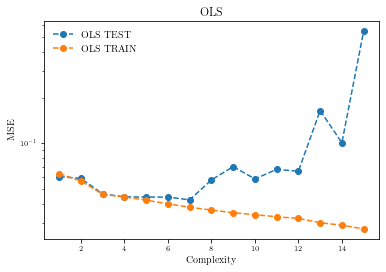

In [3]:
degrees = np.arange(1,max_degree+1)

plt.semilogy(degrees, mse_ols_test, "o--", label = "OLS TEST")
plt.semilogy(degrees, mse_ols_train, "o--", label = "OLS TRAIN")
plt.title("OLS")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(frameon=False)
plt.savefig(FIGPATH + "OLS_MSE_Bootstrap_Hastie_211.pdf")

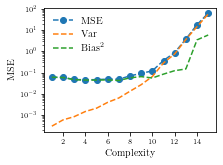

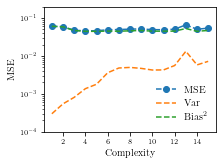

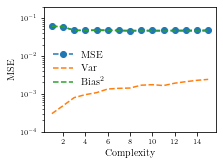

In [4]:
## BOOTSTRAP PLOTS
plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ols_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ols_boot_variance,"--", label="Var")
plt.semilogy(degrees, ols_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.tight_layout()
#plt.ylim([1e-4, 2e-1])
plt.legend(frameon=False)
plt.savefig(FIGPATH+"Franke_OLS_bootstrap.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 2e-1])
plt.tight_layout()
plt.legend(frameon=False)
plt.savefig(FIGPATH+"Franke_Ridge_bootstrap.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 2e-1])
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(FIGPATH+"Franke_LASSO_bootstrap.pdf")

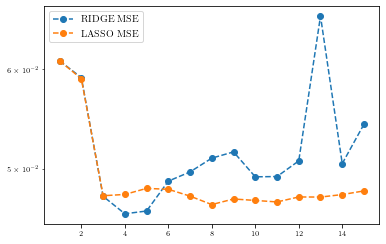

In [5]:
#plt.semilogy(degrees, ols_boot_mse,"o--",label="OLS MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="RIDGE MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="LASSO MSE")
plt.legend()

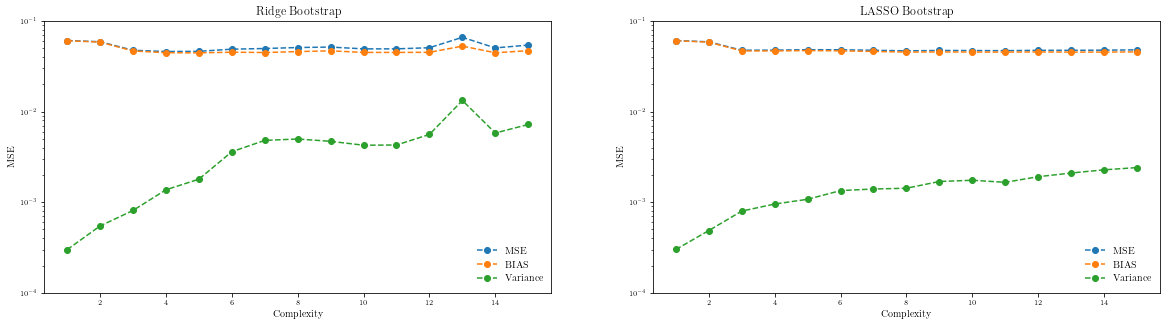

In [6]:
# Same bootstrap plots, but only better resolved LASSO & Ridge
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"o--", label="Variance")
plt.title("Ridge Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)

plt.subplot(122)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"o--", label="Variance")
plt.title("LASSO Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)
plt.show()

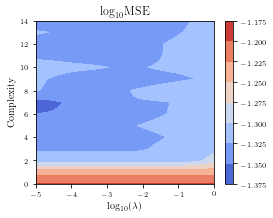

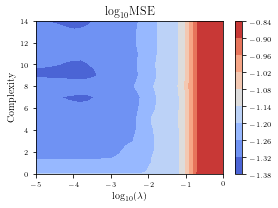

In [7]:
# CONTOUR PLOTS

# RIDGE
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), np.arange(max_degree))
plt.contourf(X, Y, np.log10(ridge_lamb_deg_mse), cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("$\log_{10}$MSE")
plt.savefig(FIGPATH + "RIDGE_CV_Franke_contour.pdf")

# LASSO
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), np.arange(max_degree))
plt.contourf(X, Y, np.log10(lasso_lamb_deg_mse), cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("$\log_{10}$MSE")
plt.tight_layout()
plt.savefig(FIGPATH + "LASSO_CV_Franke_contour.pdf")

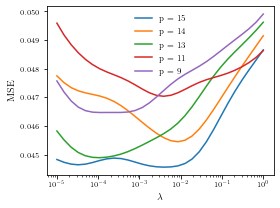

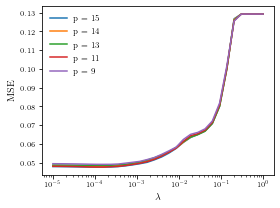

In [8]:
plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)
plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')
plt.savefig(FIGPATH+"RIDGE_best_lambda_FRANKE.pdf")

# For a copule of degrees, plot cv mse vs lambda for lasso, will break program if max_degree < 8.

plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)

plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')
plt.savefig(FIGPATH+"LASSO_best_lambda_FRANKE.pdf")

In [9]:

degree = 5

X = linear_regression.design_matrix_2D(x,y,degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
betas = linear_regression.OLS_SVD_2D(X_scaled, z)


x_plot = np.linspace(0,1,2000)
y_plot = np.linspace(0,1,2000)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot,y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()
z_plot_franke = FrankeFunction(x_plot_mesh, y_plot_mesh)
X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat,y_plot_mesh_flat,degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
z_predict_flat = (X_plot_design_scaled @ betas) + z_intercept



fig = plt.figure(figsize=(15, 10))

# Plot the analytic curve
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.set_title("Franke Function")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)

# Plot the fitted curve
ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.set_title("OLS")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0,1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_flat.reshape(2000,-1), cmap=cm.coolwarm)

"""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-9-bddbacd82c65>, line 42)

In [ ]:
# Ridge

degree = 7
ridge_lambda = 1e-4

X = linear_regression.design_matrix_2D(x,y,degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
betas_ridge = linear_regression.Ridge_2D(X_scaled, z, ridge_lambda)


x_plot = np.linspace(0,1,2000)
y_plot = np.linspace(0,1,2000)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot,y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()
z_plot_franke = FrankeFunction(x_plot_mesh, y_plot_mesh)
X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat,y_plot_mesh_flat,degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
z_predict_flat = (X_plot_design_scaled @ betas_ridge) + z_intercept


fig = plt.figure(figsize=(15, 10))

# Plot the analytic curve
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.set_title("Franke Function")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0,1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)

# Plot the fitted curve
ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.set_title("Ridge")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0,1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_flat.reshape(2000,-1), cmap=cm.coolwarm)

In [ ]:
# Lasso
degree = 10
lasso_lambda = 1e-10

X = linear_regression.design_matrix_2D(x,y,degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
clf_Lasso = skl.Lasso(alpha=lasso_lambda,fit_intercept=False).fit(X_scaled,z)


x_plot = np.linspace(0,1,2000)
y_plot = np.linspace(0,1,2000)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot,y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()
z_plot_franke = FrankeFunction(x_plot_mesh, y_plot_mesh)
X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat,y_plot_mesh_flat,degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
z_predict_flat = clf_Lasso.predict(X_plot_design_scaled) + z_intercept

fig = plt.figure(figsize=(15, 10))

# Plot the analytic curve
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.set_title("Franke Function")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0,1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)

# Plot the fitted curve
ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.set_title("Lasso")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0,1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_flat.reshape(2000,-1), cmap=cm.coolwarm)